In [1]:
# setup Pytorch env
import os
os.environ['TORCH_HOME']="/home/alex/data/pytorch"

from matplotlib import pyplot as plt
import torchvision as torchv
import torch as torch
import PIL as pil

# 05. The mechanics of learning
With the blooming of machine learning that has occurred over the last decade, the notion of machines that learn from experience has become a mainstream theme in both technical and journalistic circles. Now, how is it exactly that a machine learns? What are the mechanics of this process—or, in words, what is the algorithm behind it? From the point of view of an observer, a learning algorithm is presented with input data that is paired with desired outputs. Once learning has occurred, that algorithm will be capable of producing correct outputs when it is fed new data that is similar enough to the input data it was trained on. With deep learning, this process works even when the input data and the desired output are far from each other: when they come from different domains, like an image and a sentence describing it, as we saw in `chapter 2`.

## 5.1 A timeless lesson in modeling
Building models that allow us to explain input/output relationships dates back centuries at least. When Johannes Kepler, a German mathematical astronomer, figured out his three laws of planetary motion in the early 1600s, he based them on data collected by his mentor Tycho Brahe during naked-eye observations. Not having Newton’s law of gravitation at his disposal (actually, Newton used Kepler’s work to figure things out), Kepler extrapolated the simplest possible geometric model that could fit the data. And, by the way, it took him six years of staring at data that didn’t make sense to him, together with incremental realizations, to finally formulate these laws. We can see this process in `figure 5.1`.

<img src="images/05_01.png" style="width:600px;"/>

Kepler’s first law reads: "The orbit of every planet is an ellipse with the Sun at one of the two foci". He didn’t know what caused orbits to be ellipses, but given a set of observations for a planet, he could estimate the shape and size of the ellipse. With those two parameters computed from the data, he could tell where the planet might be during its journey in the sky. Once he figured out the second law—"A line joining a planet and the Sun sweeps out equal areas during equal intervals of time"—he could also tell when a planet would be at a particular point in space, given observations in time.

So, how did Kepler estimate the eccentricity and size of the ellipse without computers, pocket calculators, or even calculus, none of which had been invented yet? Essentially, Kepler had to try different shapes, using a certain number of observations to find the curve, then use the curve to find some more positions, for times when he had observations available, and then check whether these calculated positions agreed with the observed ones.

So let’s sum things up. Over six years, Kepler
1. Got lots of good data from his friend Brahe 

2. Tried to visualize the heck out of it, because he felt there was something fishy going on 

3. Chose the simplest possible model that had a chance to fit the data (an ellipse) 

4. Split the data so that he could work on part of it and keep an independent set for validation 

5. Started with a tentative eccentricity and size for the ellipse and iterated until the model fit the observations 

6. Validated his model on the independent observations 

7. Looked back in disbelief

There’s a data science handbook for you, all the way from 1609. The history of science is literally constructed on these seven steps. And we have learned over the centuries that deviating from them is a recipe for disaster.

This is exactly what we will set out to do in order to learn something from data. In fact, in this book there is virtually no difference between saying that we’ll fit the data or that we’ll make an algorithm learn from data. The process always involves a function with a number of unknown parameters whose values are estimated from data: in short, a model.

In this book, we’re interested in models that are not engineered for solving a specific narrow task, but that can be automatically adapted to specialize themselves for any one of many similar tasks using input and output pairs—in other words, general models trained on data relevant to the specific task at hand. In particular, `PyTorch` is designed to make it easy to create models for which the derivatives of the fitting error, with respect to the parameters, can be expressed analytically. No worries if this last sentence didn’t make any sense at all; coming next, we have a full section that hopefully clears it up for you.

This chapter is about how to automate generic function-fitting. After all, this is what we do with deep learning—deep neural networks being the generic functions we’re talking about—and PyTorch makes this process as simple and transparent as possible. In order to make sure we get the key concepts right, we’ll start with a model that is a lot simpler than a deep neural network. This will allow us to understand the mechanics of learning algorithms from first principles in this chapter, so we can move to more complicated models in `chapter 6`.

## 5.2 Learning is just parameter estimation
In this section, we’ll learn how we can take data, choose a model, and estimate the parameters of the model so that it will give good predictions on new data. To do so, we’ll leave the intricacies of planetary motion and divert our attention to the second-hardest problem in physics: calibrating instruments.

`Figure 5.2` shows the high-level overview of what we’ll implement by the end of the chapter. Given input data and the corresponding desired outputs (ground truth), as well as initial values for the weights, the model is fed input data (`forward pass`), and a measure of the error is evaluated by comparing the resulting outputs to the ground truth. In order to optimize the parameter of the model—its weights—the change in the error following a unit change in weights (that is, the gradient of the error with respect to the parameters) is computed using the chain rule for the derivative of a composite function (`backward pass`). The value of the weights is then updated in the direction that leads to a decrease in the error. The procedure is repeated until the error, evaluated on unseen data, falls below an acceptable level. If what we just said sounds obscure, we’ve got a whole chapter to clear things up. By the time we’re done, all the pieces will fall into place, and this paragraph will make perfect sense.

We’re now going to take a problem with a noisy dataset, build a model, and implement a learning algorithm for it. When we start, we’ll be doing everything by hand, but by the end of the chapter we’ll be letting `PyTorch` do all the heavy lifting for us. When we finish the chapter, we will have covered many of the essential concepts that underlie training deep neural networks, even if our motivating example is very simple and our model isn’t actually a neural network.

<img src="images/05_02.png" style="width:600px;"/>

### 5.2.1 A hot problem
We just got back from a trip to some obscure location, and we brought back a fancy, wall-mounted analog thermometer. It looks great, and it’s a perfect fit for our living room. Its only flaw is that it doesn’t show units. Not to worry, we’ve got a plan: we’ll build a dataset of readings and corresponding temperature values in our favorite units, choose a model, adjust its weights iteratively until a measure of the error is low enough, and finally be able to interpret the new readings in units we understand.

### 5.2.2 Gathering some data
We’ll start by making a note of temperature data in good old Celsius and measurements from our new thermometer, and figure things out. After a couple of weeks, here’s the data:

In [2]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c) 
t_u = torch.tensor(t_u)

Here, the $t\_c$ values are temperatures in Celsius, and the $t\_u$ values are our unknown units. We can expect noise in both measurements, coming from the devices themselves and from our approximate readings. For convenience, we’ve already put the data into tensors; we’ll use it in a minute.

### 5.2.3 Visualizing the data
A quick plot of our data in `figure 5.3` tells us that it’s noisy, but we think there’s a pattern here.

<img src="images/05_03.png" style="width:600px;"/>

### 5.2.4 Choosing a linear model as a first try
In the absence of further knowledge, we assume the simplest possible model for converting between the two sets of measurements, just like Kepler might have done. The two may be linearly related—that is, multiplying $t\_u$ by a factor and adding a constant, we may get the temperature in Celsius (up to an error that we omit):

$$t\_c = w * t\_u + b$$

Is this a reasonable assumption? Probably; we’ll see how well the final model performs. We chose to name $w$ and $b$ after weight and bias, two very common terms for linear scaling and the additive constant—we’ll bump into those all the time.

OK, now we need to estimate $w$ and $b$, the parameters in our model, based on the data we have. We must do it so that temperatures we obtain from running the unknown temperatures $t\_u$ through the model are close to temperatures we actually measured in Celsius. If that sounds like fitting a line through a set of measurements, well, yes, because that’s exactly what we’re doing. We’ll go through this simple example using `PyTorch` and realize that training a neural network will essentially involve changing the model for a slightly more elaborate one, with a few (or a metric ton) more parameters.

Let’s flesh it out again: we have a model with some unknown parameters, and we need to estimate those parameters so that the error between predicted outputs and measured values is as low as possible. We notice that we still need to exactly define a measure of the error. Such a measure, which we refer to as the *loss function*, should be high if the error is high and should ideally be as low as possible for a perfect match. Our optimization process should therefore aim at finding $w$ and $b$ so that the loss function is at a minimum.

## 5.3 Less loss is what we want
A `loss function` (or `cost function`) is a function that computes a single numerical value that the learning process will attempt to minimize. The calculation of loss typically involves taking the difference between the desired outputs for some training samples and the outputs actually produced by the model when fed those samples. In our case, that would be the difference between the predicted temperatures $t\_p$ output by our model and the actual measurements: $t\_p – t\_c$.

We need to make sure the loss function makes the loss positive both when $t\_p$ is greater than and when it is less than the true $t\_c$, since the goal is for $t\_p$ to match $t\_c$. We have a few choices, the most straightforward being $|t\_p – t\_c|$ and $(t\_p – t\_c)^2$. Based on the mathematical expression we choose, we can emphasize or discount certain errors. Conceptually, a loss function is a way of prioritizing which errors to fix from our training samples, so that our parameter updates result in adjustments to the outputs for the highly weighted samples instead of changes to some other samples’ output that had a smaller loss.

Both of the example loss functions have a clear minimum at zero and grow monotonically as the predicted value moves further from the true value in either direction. Because the steepness of the growth also monotonically increases away from the minimum, both of them are said to be *convex*. Since our model is linear, the loss as a function of $w$ and $b$ is also convex. Cases where the loss is a convex function of the model parameters are usually great to deal with because we can find a minimum very efficiently through specialized algorithms. However, we will instead use less powerful but more generally applicable methods in this chapter. We do so because for the deep neural networks we are ultimately interested in, the loss is not a convex function of the inputs.

For our two loss functions $|t\_p – t\_c|$ and $(t\_p – t\_c)^2$, as shown in `figure 5.4`, we notice that the square of the differences behaves more nicely around the minimum: the derivative of the error-squared loss with respect to $t\_p$ is zero when $t\_p$ equals $t\_c$. The absolute value, on the other hand, has an undefined derivative right where we’d like to converge. This is less of an issue in practice than it looks like, but we’ll stick to the square of differences for the time being.

<img src="images/05_04.png" style="width:500px;"/>

It’s worth noting that the square difference also penalizes wildly wrong results more than the absolute difference does. Often, having more slightly wrong results is better than having a few wildly wrong ones, and the squared difference helps prioritize those as desired.

### 5.3.1 From problem back to PyTorch
We’ve figured out the model and the loss function—we’ve already got a good part of the high-level picture in `figure 5.2` figured out. Now we need to set the learning process in motion and feed it actual data. Also, enough with math notation; let’s switch to `PyTorch`—after all, we came here for the fun.

We’ve already created our data tensors, so now let’s write out the model as a Python function:

In [3]:
def model(t_u, w, b):
    return w * t_u + b

We’re expecting $t\_u$, $w$, and $b$ to be the input tensor, weight parameter, and bias parameter, respectively. In our model, the parameters will be `PyTorch` scalars (aka zero-dimensional tensors), and the product operation will use broadcasting to yield the returned tensors. Anyway, time to define our loss:

In [4]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

Note that we are building a tensor of differences, taking their square element-wise, and finally producing a scalar loss function by averaging all of the elements in the resulting tensor. It is a *mean square loss*.

We can now initialize the parameters, invoke the model,

In [5]:
w = torch.ones(()) 
b = torch.zeros(())
t_p = model(t_u, w, b) 
w.shape, b.shape, t_p

(torch.Size([]),
 torch.Size([]),
 tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
         48.4000, 60.4000, 68.4000]))

and check the value of the loss:

In [6]:
loss = loss_fn(t_p, t_c) 
loss

tensor(1763.8846)

We implemented the model and the loss in this section. We’ve finally reached the meat of the example: how do we estimate $w$ and $b$ such that the loss reaches a minimum? We’ll first work things out by hand and then learn how to use `PyTorch`’s superpowers to solve the same problem in a more general, off-the-shelf way.

##### Broadcasting
We mentioned broadcasting in `chapter 3`, and we promised to look at it more carefully when we need it. In our example, we have two scalars (zero-dimensional tensors) $w$ and $b$, and we multiply them with and add them to vectors (one-dimensional tensors) of length $b$.

Usually—and in early versions of `PyTorch`, too—we can only use element-wise binary operations such as addition, subtraction, multiplication, and division for arguments of the same shape. The entries in matching positions in each of the tensors will be used to calculate the corresponding entry in the result tensor.

Broadcasting, which is popular in `NumPy` and adapted by `PyTorch`, relaxes this assumption for most binary operations. It uses the following rules to match tensor elements:
+ For each index dimension, counted from the back, if one of the operands is size 1 in that dimension, `PyTorch` will use the single entry along this dimension with each of the entries in the other tensor along this dimension.

+ If both sizes are greater than 1, they must be the same, and natural matching is used.

+ If one of the tensors has more index dimensions than the other, the entirety of the other tensor will be used for each entry along these dimensions.

This sounds complicated (and it can be error-prone if we don’t pay close attention, which is why we have named the tensor dimensions as shown in `section 3.4`), but usually, we can either write down the tensor dimensions to see what happens or picture what happens by using space dimensions to show the broadcasting, as in the following figure.

Of course, this would all be theory if we didn’t have some code examples:

In [7]:
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2, 1, 1) 
print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"        z: {z.shape}, a: {a.shape}") 
print("x * y:", (x * y).shape) 
print("y * z:", (y * z).shape) 
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


In [8]:
z = torch.ones(3,3)
a = torch.arange(2)+2
a = a.view(2,1,1)
a.shape, a, z

(torch.Size([2, 1, 1]),
 tensor([[[2]],
 
         [[3]]]),
 tensor([[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]))

In [9]:
z*a

tensor([[[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],

        [[3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.]]])

## 5.4 Down along the gradient
We’ll optimize the loss function with respect to the parameters using the gradient descent algorithm. In this section, we’ll build our intuition for how gradient descent works from first principles, which will help us a lot in the future. As we mentioned, there are ways to solve our example problem more efficiently, but those approaches aren’t applicable to most deep learning tasks. Gradient descent is actually a very simple idea, and it scales up surprisingly well to large neural network models with millions of parameters.

Let’s start with a mental image, which we conveniently sketched out in `figure 5.5`. Suppose we are in front of a machine sporting two knobs, labeled $w$ and $b$. We are allowed to see the value of the loss on a screen, and we are told to minimize that value. Not knowing the effect of the knobs on the loss, we start fiddling with them and decide for each knob which direction makes the loss decrease. We decide to rotate both knobs in their direction of decreasing loss. Suppose we’re far from the optimal value: we’d likely see the loss decrease quickly and then slow down as it gets closer to the minimum. We notice that at some point, the loss climbs back up again, so we invert the direction of rotation for one or both knobs. We also learn that when the loss changes slowly, it’s a good idea to adjust the knobs more finely, to avoid reaching the point where the loss goes back up. After a while, eventually, we converge to a minimum.

<img src="images/05_05.png" style="width:250px;"/>

### 5.4.1 Decreasing loss
Gradient descent is not that different from the scenario we just described. The idea is to compute the rate of change of the loss with respect to each parameter, and modify each parameter in the direction of decreasing loss. Just like when we were fiddling with the knobs, we can estimate the rate of change by adding a small number to $w$ and $b$ and seeing how much the loss changes in that neighborhood:

In [10]:
delta = 0.1
loss_rate_of_change_w = \
    (loss_fn(model(t_u, w+delta, b), t_c)-loss_fn(model(t_u, w-delta, b), t_c)) / (2.0*delta)

This is saying that in the neighborhood of the current values of $w$ and $b$, a unit increase in $w$ leads to some change in the loss. If the change is negative, then we need to increase $w$ to minimize the loss, whereas if the change is positive, we need to decrease $w$. By how much? Applying a change to $w$ that is proportional to the rate of change of the loss is a good idea, especially when the loss has several parameters: we apply a change to those that exert a significant change on the loss. It is also wise to change the parameters slowly in general, because the rate of change could be dramatically different at a distance from the neighborhood of the current $w$ value. Therefore, we typically should scale the rate of change by a small factor. This scaling factor has many names; the one we use in machine learning is `learning_rate`:

In [11]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w

We can do the same with $b$:

In [12]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b+delta), t_c)-loss_fn(model(t_u, w, b-delta), t_c)) / (2.0*delta)

b = b - learning_rate * loss_rate_of_change_b

This represents the basic parameter-update step for gradient descent. By reiterating these evaluations (and provided we choose a small enough learning rate), we will converge to an optimal value of the parameters for which the loss computed on the given data is minimal. We’ll show the complete iterative process soon, but the way we just computed our rates of change is rather crude and needs an upgrade before we move on. Let’s see why and how.

### 5.4.2 Getting analytical
Computing the rate of change by using repeated evaluations of the model and loss in order to probe the behavior of the loss function in the neighborhood of $w$ and $b$ doesn’t scale well to models with many parameters. Also, it is not always clear how large the neighborhood should be. We chose `delta` equal to $0.1$ in the previous section, but it all depends on the shape of the loss as a function of $w$ and $b$. If the loss changes too quickly compared to `delta`, we won’t have a very good idea of in which direction the loss is decreasing the most.

What if we could make the neighborhood infinitesimally small, as in `figure 5.6`? That’s exactly what happens when we analytically take the derivative of the loss with respect to a parameter. In a model with two or more parameters like the one we’re dealing with, we compute the individual derivatives of the loss with respect to each parameter and put them in a vector of derivatives: the *gradient*.

<img src="images/05_06.png" style="width:500px;"/>

##### COMPUTING THE DERIVATIVES
In order to compute the derivative of the loss with respect to a parameter, we can apply the chain rule and compute the derivative of the loss with respect to its input (which is the output of the model), times the derivative of the model with respect to the parameter:

$$\frac{\partial{\textit{loss_fn}}}{\partial w}  = \frac{\partial{\textit{loss_fn}}}{\partial t\_p} * \frac{\partial{t\_p}}{\partial w}$$

Recall that our model is a linear function, and our loss is a sum of squares. Let’s figure out the expressions for the derivatives. Recalling the expression for the loss:

In [13]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

Remembering that $\frac{\partial x^2}{\partial x} = 2x$, we get:

In [14]:
def dloss_fn(t_p, t_c):
    # The division is from the derivative of mean
    dsq_diffs = 2 *(t_p - t_c)/t_p.size(0) 
    return dsq_diffs

##### APPLYING THE DERIVATIVES TO THE MODEL
For the model, recalling that our model is:

In [15]:
def model(t_u, w, b):
    return w * t_u + b

we get these derivatives:

In [16]:
def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

##### DEFINING THE GRADIENT FUNCTION
Putting all of this together, the function returning the gradient of the loss with respect to $w$ and $b$ is:

In [17]:
def grad_fn(t_u, t_c, t_p, w, b):
    # The summation is the reverse of the broadcasting we implicitly do when 
    # applying the parameters to an entire vector of inputs in the model.
    dloss_dtp = dloss_fn(t_p, t_c) 
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b) 
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b) 
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

The same idea expressed in mathematical notation is shown in `figure 5.7`. Again, we’re averaging (that is, summing and dividing by a constant) over all the data points to get a single scalar quantity for each partial derivative of the loss.

<img src="images/05_07.png" style="width:600px;"/>

### 5.4.3 Iterating to fit the model
We now have everything in place to optimize our parameters. Starting from a tentative value for a parameter, we can iteratively apply updates to it for a fixed number of iterations, or until $w$ and $b$ stop changing. There are several stopping criteria; for now, we’ll stick to a fixed number of iterations.

##### THE TRAINING LOOP
Since we’re at it, let’s introduce another piece of terminology. We call a training iteration during which we update the parameters for all of our training samples an `epoch`.

In [18]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>
        params = params - learning_rate * grad
        if epoch in {1, 2, 3, 4, 5, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')
        if not torch.isfinite(loss).all():
            print('loss is inf, abort')
            break  # <3>
    return params

The actual logging logic used for the output in this text is more complicated (see `cell 15` in the same [notebook](http://mng.bz/pBB8)), but the differences are unimportant for understanding the core concepts in this chapter.

Now, let’s invoke our training loop:

In [19]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, params = torch.tensor([1.0, 0.0]),
    t_u = t_u, t_c = t_c)

Epoch 1, Loss 1763.884644
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2969,   82.6000])
Epoch 2, Loss 5802485.500000
    Params: tensor([2568.4014,   45.1637])
    Grad:   tensor([-261257.4219,   -4598.9712])
Epoch 3, Loss 19408035840.000000
    Params: tensor([-148527.7344,   -2616.3933])
    Grad:   tensor([15109614.0000,   266155.7188])
Epoch 4, Loss 64915909902336.000000
    Params: tensor([8589999.0000,  151310.8594])
    Grad:   tensor([-8.7385e+08, -1.5393e+07])
...
Epoch 5, Loss 217130559820791808.000000
    Params: tensor([-4.9680e+08, -8.7510e+06])
    Grad:   tensor([5.0539e+10, 8.9023e+08])
Epoch 10, Loss 90901154706620645225508955521810432.000000
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19])
loss is inf, abort


tensor([-1.8590e+19, -3.2746e+17])

##### OVERTRAINING
Wait, what happened? Our training process literally blew up, leading to losses becoming `inf`. This is a clear sign that params is receiving updates that are too large, and their values start oscillating back and forth as each update overshoots and the next overcorrects even more. The optimization process is unstable: it diverges instead of converging to a minimum. We want to see smaller and smaller updates to params, not larger, as shown in `figure 5.8`.

<img src="images/05_08.png" style="width:550px;"/>

How can we limit the magnitude of $\textit{learning_rate} * \textit{grad}$? Well, that looks easy. We could simply choose a smaller `learning_rate`, and indeed, the learning rate is one of the things we typically change when training does not go as well as we would like. We usually change learning rates by orders of magnitude, so we might try with $1e^{-3}$ or $1e^{-4}$, which would decrease the magnitude of the updates by orders of magnitude. Let’s go with $1e^{-4}$ and see how it works out:

In [20]:
training_loop(
    n_epochs = 20, #100, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884644
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2969,   82.6000])
Epoch 2, Loss 323.090546
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4667,  16.5122])
Epoch 4, Loss 37.552845
    Params: tensor([ 0.2543, -0.0143])
    Grad:   tensor([315.0790,   8.5787])
...
Epoch 5, Loss 30.540285
    Params: tensor([ 0.2413, -0.0149])
    Grad:   tensor([129.6733,   5.3127])
Epoch 10, Loss 29.105242
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...


tensor([ 0.2323, -0.0196])

Nice—the behavior is now stable. But there’s another problem: the updates to parameters are very small, so the loss decreases very slowly and eventually stalls. We could obviate this issue by making `learning_rate` adaptive: that is, change according to the magnitude of updates. There are optimization schemes that do that, and we’ll see one toward the end of this chapter, in `section 5.5.2`.

However, there’s another potential troublemaker in the update term: the gradient itself. Let’s go back and look at grad at `epoch 1` during optimization.

### 5.4.4 Normalizing inputs
We can see that the first-epoch gradient for the weight is about $50$ times larger than the gradient for the bias. This means the weight and bias live in differently scaled spaces. If this is the case, a learning rate that’s large enough to meaningfully update one will be so large as to be unstable for the other; and a rate that’s appropriate for the other won’t be large enough to meaningfully change the first. That means we’re not going to be able to update our parameters unless we change something about our formulation of the problem. We could have individual learning rates for each parameter, but for models with many parameters, this would be too much to bother with; it’s babysitting of the kind we don’t like.

There’s a simpler way to keep things in check: changing the inputs so that the gradients aren’t quite so different. We can make sure the range of the input doesn’t get too far from the range of $–1.0 \sim 1.0$, roughly speaking. In our case, we can achieve something close enough to that by simply multiplying $t\_u$ by $0.1$:

In [21]:
t_un = 0.1 * t_u

At this point, we can run the training loop on our normalized input:

In [22]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, # <1>
    t_c = t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574917
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
Epoch 4, Loss 29.756193
    Params: tensor([2.2616, 0.1004])
    Grad:   tensor([-5.2218,  2.1327])
...
Epoch 5, Loss 29.507149
    Params: tensor([2.2853, 0.0740])
    Grad:   tensor([-2.3715,  2.6310])
Epoch 10, Loss 29.030487
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941875
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

Even though we set our learning rate back to $1e^{-2}$, parameters don’t blow up during iterative updates. Let’s take a look at the gradients: they’re of similar magnitude, so using a single `learning_rate` for both parameters works just fine. We could probably do a better job of normalization than a simple rescaling by a factor of $10$, but since doing so is good enough for our needs, we’re going to stick with that for now.

> **NOTE**
> 
> The normalization here absolutely helps get the network trained, but you could make an argument that it’s not strictly needed to optimize the parameters for this particular problem. That’s absolutely true! This problem is small enough that there are numerous ways to beat the parameters into submission. However, for larger, more sophisticated problems, normalization is an easy and effective (if not crucial!) tool to use to improve model convergence.

Let’s run the loop for enough iterations to see the changes in params get small. We’ll change `n_epochs` to $5000$:

In [23]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un, 
    t_c = t_c, 
    print_params = False)
params

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574917
Epoch 3, Loss 30.871077
Epoch 4, Loss 29.756193
...
Epoch 5, Loss 29.507149
Epoch 10, Loss 29.030487
Epoch 11, Loss 28.941875
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


tensor([  5.3671, -17.3012])

Good: our loss decreases while we change parameters along the direction of gradient descent. It doesn’t go exactly to zero; this could mean there aren’t enough iterations to converge to zero, or that the data points don’t sit exactly on a line. As we anticipated, our measurements were not perfectly accurate, or there was noise involved in the reading.

But look: the values for $w$ and $b$ look an awful lot like the numbers we need to use to convert Celsius to Fahrenheit (after accounting for our earlier normalization when we multiplied our inputs by $0.1$). The exact values would be $w=5.5556$ and $b=17.7778$. Our fancy thermometer was showing temperatures in Fahrenheit the whole time. No big discovery, except that our gradient descent optimization process works!

### 5.4.5 Visualizing (again)
Let’s revisit something we did right at the start: plotting our data. Seriously, this is the first thing anyone doing data science should do. Always plot the heck out of the data:

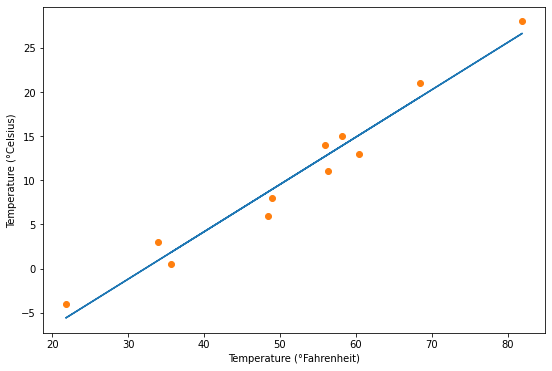

In [24]:
# Remember that we’re training on the normalized unknown units. 
# We also use argument unpacking.
t_p = model(t_un, *params)

# The plot of our linear-fit model (solid line) vs. our input data (circles)
fig = plt.figure(figsize=(9,6)) 
plt.xlabel("Temperature (°Fahrenheit)") 
plt.ylabel("Temperature (°Celsius)") 
plt.plot(t_u.numpy(), t_p.detach().numpy()) 
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

We are using a Python trick called *argument unpacking* here: `*params` means to pass the elements of params as individual arguments. In Python, this is usually done with lists or tuples, but we can also use argument unpacking with `PyTorch` tensors, which are split along the leading dimension. So here, `model(t_un, *params)` is equivalent to `model(t_un, params[0], params[1])`.

This code produces `figure 5.9`. Our linear model is a good model for the data, it seems. It also seems our measurements are somewhat erratic. We should either call our optometrist for a new pair of glasses or think about returning our fancy thermometer.


## 5.5 PyTorch’s autograd: Backpropagating all things
In our little adventure, we just saw a simple example of *backpropagation*: we computed the gradient of a composition of functions—the model and the loss—with respect to their innermost parameters ($w$ and $b$) by propagating derivatives backward using the chain rule. The basic requirement here is that all functions we’re dealing with can be differentiated analytically. If this is the case, we can compute the gradient—what we earlier called "the rate of change of the loss"—with respect to the parameters in one sweep.

Even if we have a complicated model with millions of parameters, as long as our model is differentiable, computing the gradient of the loss with respect to the parameters amounts to writing the analytical expression for the derivatives and evaluating them once. Granted, writing the analytical expression for the derivatives of a very deep composition of linear and nonlinear functions is not a lot of fun. It isn’t particularly quick, either.

### 5.5.1 Computing the gradient automatically
This is when `PyTorch` tensors come to the rescue, with a `PyTorch` component called `autograd`. `Chapter 3` presented a comprehensive overview of what tensors are and what functions we can call on them. We left out one very interesting aspect, however: `PyTorch` tensors can remember where they come from, in terms of the operations and parent tensors that originated them, and they can automatically provide the chain of derivatives of such operations with respect to their inputs. This means we won’t need to derive our model by hand; given a forward expression, no matter how nested, `PyTorch` will automatically provide the gradient of that expression with respect to its input parameters.

##### APPLYING AUTOGRAD
At this point, the best way to proceed is to rewrite our thermometer calibration code, this time using `autograd`, and see what happens. First, we recall our model and loss function.

In [25]:
def model(t_u, w, b):
    return w * t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

Let’s again initialize a parameters tensor:

In [26]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

##### USING THE GRAD ATTRIBUTE
Notice the `requires_grad=True` argument to the tensor constructor? That argument is telling `PyTorch` to track the entire family tree of tensors resulting from operations on `params`. In other words, any tensor that will have `params` as an ancestor will have access to the chain of functions that were called to get from params to that tensor. In case these functions are differentiable (and most `PyTorch` tensor operations will be), the value of the derivative will be automatically populated as a `grad` attribute of the `params` tensor.

In general, all `PyTorch` tensors have an attribute named `grad`. Normally, it’s `None`:

In [27]:
params.grad is None

True

All we have to do to populate it is to start with a tensor with `requires_grad` set to `True`, then call the model and compute the loss, and then call `backward` on the `loss` tensor:

In [28]:
loss = loss_fn(model(t_u, *params), t_c) 
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

At this point, the `grad` attribute of `params` contains the derivatives of the loss with respect to each element of params.

When we compute our loss while the parameters $w$ and $b$ require gradients, in addition to performing the actual computation, `PyTorch` creates the autograd graph with the operations (in black circles) as nodes, as shown in the top row of `figure 5.10`. When we call `loss.backward()`, `PyTorch` traverses this graph in the reverse direction to compute the gradients, as shown by the arrows in the bottom row of the figure.

<img src="images/05_10.png" style="width:600px;"/>

##### ACCUMULATING GRAD FUNCTIONS
We could have any number of tensors with `requires_grad` set to `True` and any composition of functions. In this case, `PyTorch` would compute the derivatives of the loss throughout the chain of functions (the computation graph) and accumulate their values in the `grad` attribute of those tensors (the leaf nodes of the graph).

Alert! ***Big gotcha ahead***. This is something `PyTorch` newcomers—and a lot of more experienced folks, too—trip up on regularly. We just wrote accumulate, not store.

> **WARNING**
> 
> Calling `backward` will lead derivatives to *accumulate* at leaf nodes. We need to zero the gradient explicitly after using it for parameter updates.

Let’s repeat together: calling `backward` will lead derivatives to accumulate at leaf nodes. So if `backward` was called earlier, the loss is evaluated again, `backward` is called again (as in any training loop), and the gradient at each leaf is accumulated (that is, summed) on top of the one computed at the previous iteration, which leads to an incorrect value for the gradient.

In order to prevent this from occurring, we need to *zero the gradient explicitly* at each iteration. We can do this easily using the in-place `zero_` method:

In [29]:
if params.grad is not None:
    params.grad.zero_()

> **NOTE**
> 
> You might be curious why zeroing the gradient is a required step instead of zeroing happening automatically whenever we call `backward`. Doing it this way provides more flexibility and control when working with gradients in complicated models.

Having this reminder drilled into our heads, let’s see what our autograd-enabled training code looks like, start to finish:

In [30]:
def training_loop_autograd(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:  # <1>
            params.grad.zero_()
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        loss.backward()
        with torch.no_grad():  # <2>
            params -= learning_rate * params.grad
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

Note that our code updating `params` is not quite as straightforward as we might have expected. There are two particularities:

+ first, we are encapsulating the update in a `no_grad` context using the Python `with` statement. This means within the `with` block, the `PyTorch` `autograd` mechanism should look away: that is, not add edges to the forward graph. In fact, when we are executing this bit of code, the forward graph that `PyTorch` records is consumed when we call backward, leaving us with the params leaf node. But now we want to change this leaf node before we start building a fresh forward graph on top of it. While this use case is usually wrapped inside the optimizers we discuss in `section 5.5.2`, we will take a closer look when we see another common use of `no_grad` in `section 5.5.4`.

+ second, we update params in place. This means we keep the same `params` tensor around but subtract our update from it. When using `autograd`, we usually avoid in-place updates because `PyTorch`’s `autograd` engine might need the values we would be modifying for the backward pass. Here, however, we are operating without `autograd`, and it is beneficial to keep the `params` tensor. Not replacing the parameters by assigning new tensors to their variable name will become crucial when we register our parameters with the optimizer in `section 5.5.2`.

Let’s see if it works:

In [31]:
training_loop_autograd(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0], requires_grad=True), # <1> 
    t_u = t_un, # <2> 
    t_c = t_c)

Epoch 500, Loss 7.860116
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

The result is the same as we got previously. Good for us! It means that while we are capable of computing derivatives by hand, we no longer need to.

### 5.5.2 Optimizers a la carte
In the example code, we used vanilla gradient descent for optimization, which worked fine for our simple case. Needless to say, there are several optimization strategies and tricks that can assist convergence, especially when models get complicated.

We’ll dive deeper into this topic in later chapters, but now is the right time to introduce the way `PyTorch` abstracts the optimization strategy away from user code: that is, the training loop we’ve examined. This saves us from the boilerplate busywork of having to update each and every parameter to our model ourselves. The `torch` module has an `optim` submodule where we can find classes implementing different optimization algorithms. Here’s an abridged list:

In [32]:
[x for x in dir(torch.optim) if not x.startswith("__")]

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 'lr_scheduler']

Every optimizer constructor takes a list of parameters (aka `PyTorch` tensors, typically with `requires_grad` set to `True`) as the first input. All parameters passed to the optimizer are retained inside the optimizer object so the optimizer can update their values and access their `grad` attribute, as represented in `figure 5.11`.

<img src="images/05_11.png" style="width:600px;"/>

Each optimizer exposes two methods: 
+ *zero_grad()*: zeroes the grad attribute of all the parameters passed to the optimizer upon construction
+ *step()*: updates the value of those parameters according to the optimization strategy implemented by the specific optimizer

##### USING A GRADIENT DESCENT OPTIMIZER
Let’s create `params` and instantiate a gradient descent optimizer:

In [33]:
params = torch.tensor([1.0, 0.0], requires_grad=True) 
learning_rate = 1e-5
optimizer = torch.optim.SGD([params], lr=learning_rate)

Here `SGD` stands for `stochastic gradient descent`. Actually, the optimizer itself is exactly a vanilla gradient descent (as long as the momentum argument is set to $0.0$, which is the default). The term stochastic comes from the fact that the gradient is typically obtained by averaging over a random subset of all input samples, called a `minibatch`. However, the optimizer does not know if the loss was evaluated on all the samples (vanilla) or a random subset of them (stochastic), so the algorithm is literally the same in the two cases.

Anyway, let’s take our fancy new optimizer for a spin:

In [34]:
t_p = model(t_u, *params) 
loss = loss_fn(t_p, t_c) 
loss.backward()
optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

The value of `params` is updated upon calling step without us having to touch it ourselves! What happens is that the optimizer looks into `params.grad` and updates `params`, subtracting `learning_rate` times `grad` from it, exactly as in our former hand-rolled code.

Ready to stick this code in a training loop? Nope! The big gotcha almost got us-we forgot to zero out the gradients. Had we called the previous code in a loop, gradients would have accumulated in the leaves at every call to `backward`, and our gradient descent would have been all over the place! Here’s the loop-ready code, with the extra `zero_grad` at the correct spot (right before the call to `backward`):

In [35]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = torch.optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad() # <1>
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

Perfect! See how the `optim` module helps us abstract away the specific optimization scheme? All we have to do is provide a list of params to it (that list can be extremely long, as is needed for very deep neural network models), and we can forget about the details.

Let’s update our training loop accordingly:

In [36]:
def training_loop_optim(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [37]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = torch.optim.SGD([params], lr=learning_rate) # <1>

training_loop_optim(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params, # <1> 
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860118
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927680
Epoch 4500, Loss 2.927651
Epoch 5000, Loss 2.927648


tensor([  5.3671, -17.3012], requires_grad=True)

Again, we get the same result as before. Great: this is further confirmation that we know how to descend a gradient by hand!

##### TESTING OTHER OPTIMIZERS
In order to test more optimizers, all we have to do is instantiate a different optimizer, say `Adam`, instead of `SGD`. The rest of the code stays as it is. Pretty handy stuff.

We won’t go into much detail about `Adam`; suffice to say that it is a more sophisticated optimizer in which the learning rate is set adaptively. In addition, it is a lot less sensitive to the scaling of the parameters—so insensitive that we can go back to using the original (non-normalized) input $t\_u$, and even increase the learning rate to $1e^{-1}$, and `Adam` won’t even blink:

In [38]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = torch.optim.Adam([params], lr=learning_rate) # <1>

training_loop_optim(
    n_epochs = 2000, 
    optimizer = optimizer,
    params = params,
    t_u = t_u, # <2> 
    t_c = t_c)

Epoch 500, Loss 7.612903
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928578
Epoch 2000, Loss 2.927646


tensor([  0.5367, -17.3021], requires_grad=True)

The optimizer is not the only flexible part of our training loop. Let’s turn our attention to the model. In order to train a neural network on the same data and the same loss, all we would need to change is the model function. It wouldn’t make particular sense in this case, since we know that converting Celsius to Fahrenheit amounts to a linear transformation, but we’ll do it anyway in `chapter 6`. We’ll see quite soon that neural networks allow us to remove our arbitrary assumptions about the shape of the function we should be approximating. Even so, we’ll see how neural networks manage to be trained even when the underlying processes are highly nonlinear (such in the case of describing an image with a sentence, as we saw in `chapter 2`).

We have touched on a lot of the essential concepts that will enable us to train complicated deep learning models while knowing what’s going on under the hood: backpropagation to estimate gradients, autograd, and optimizing weights of models using gradient descent or other optimizers. Really, there isn’t a lot more. The rest is mostly filling in the blanks, however extensive they are.

Next up, we’re going to offer an aside on how to split our samples, because that sets up a perfect use case for learning how to better control autograd.

### 5.5.3 Training, validation, and overfitting
Johannes Kepler taught us one last thing that we didn’t discuss so far, remember? He kept part of the data on the side so that he could validate his models on independent observations. This is a vital thing to do, especially when the model we adopt could potentially approximate functions of any shape, as in the case of neural networks. In other words, a highly adaptable model will tend to use its many parameters to make sure the loss is minimal at the data points, but we’ll have no guarantee that the model behaves well away from or in between the data points. After all, that’s what we’re asking the optimizer to do: minimize the loss at the data points. Sure enough, if we had independent data points that we didn’t use to evaluate our loss or descend along its negative gradient, we would soon find out that evaluating the loss at those independent data points would yield higher-than-expected loss. We have already mentioned this phenomenon, called *overfitting*.

The first action we can take to combat overfitting is recognizing that it might happen. In order to do so, as Kepler figured out in $1600$, we must take a few data points out of our dataset (the *validation set*) and only fit our model on the remaining data points (the *training set*), as shown in `figure 5.12`. Then, while we’re fitting the model, we can evaluate the loss once on the training set and once on the validation set. When we’re trying to decide if we’ve done a good job of fitting our model to the data, we must look at both!

<img src="images/05_12.png" style="width:600px;"/>

##### EVALUATING THE TRAINING LOSS
The training loss will tell us if our model can fit the training set at all—in other words, if our model has enough capacity to process the relevant information in the data. If our mysterious thermometer somehow managed to measure temperatures using a logarithmic scale, our poor linear model would not have had a chance to fit those measurements and provide us with a sensible conversion to Celsius. In that case, our training loss (the loss we were printing in the training loop) would stop decreasing well before approaching zero.

A deep neural network can potentially approximate complicated functions, provided that the number of neurons, and therefore parameters, is high enough. The fewer the number of parameters, the simpler the shape of the function our network will be able to approximate. So, rule 1: if the training loss is not decreasing, chances are the model is too simple for the data. The other possibility is that our data just doesn’t contain meaningful information that lets it explain the output: if the nice folks at the shop sell us a barometer instead of a thermometer, we will have little chance of predicting temperature in Celsius from just pressure, even if we use the latest neural network architecture from [Quebec](www.umontreal.ca/en/artificialintelligence).

##### GENERALIZING TO THE VALIDATION SET
What about the validation set? Well, if the loss evaluated in the validation set doesn’t decrease along with the training set, it means our model is improving its fit of the samples it is seeing during training, but it is not generalizing to samples outside this precise set. As soon as we evaluate the model at new, previously unseen points, the values of the loss function are poor. So, rule 2: if the training loss and the validation loss diverge, we’re overfitting.

Let’s delve into this phenomenon a little, going back to our thermometer example. We could have decided to fit the data with a more complicated function, like a piecewise polynomial or a really large neural network. It could generate a model meandering its way through the data points, as in `figure 5.13`, just because it pushes the loss very close to zero. Since the behavior of the function away from the data points does not increase the loss, there’s nothing to keep the model in check for inputs away from the training data points.

<img src="images/05_13.png" style="width:600px;"/>

What’s the cure, though? Good question. From what we just said, overfitting really looks like a problem of making sure the behavior of the model in between data points is sensible for the process we’re trying to approximate. First of all, we should make sure we get enough data for the process. If we collected data from a sinusoidal process by sampling it regularly at a low frequency, we would have a hard time fitting a model to it.

Assuming we have enough data points, we should make sure the model that is capable of fitting the training data is as regular as possible in between them. There are several ways to achieve this. One is adding penalization terms to the loss function, to make it cheaper for the model to behave more smoothly and change more slowly (up to a point). Another is to add noise to the input samples, to artificially create new data points in between training data samples and force the model to try to fit those, too. There are several other ways, all of them somewhat related to these. But the best favor we can do to ourselves, at least as a first move, is to make our model simpler. From an intuitive standpoint, a simpler model may not fit the training data as perfectly as a more complicated model would, but it will likely behave more regularly in between data points.

We’ve got some nice trade-offs here. On the one hand, we need the model to have enough capacity for it to fit the training set. On the other, we need the model to avoid overfitting. Therefore, in order to choose the right size for a neural network model in terms of parameters, the process is based on two steps: increase the size until it fits, and then scale it down until it stops overfitting.

We’ll see more about this in `chapter 12`—we’ll discover that our life will be a balancing act between fitting and overfitting. For now, let’s get back to our example and see how we can split the data into a training set and a validation set. We’ll do it by shuffling t_u and t_c the same way and then splitting the resulting shuffled tensors into two parts.

##### SPLITTING A DATASET
Shuffling the elements of a tensor amounts to finding a permutation of its indices. The `randperm` function does exactly this:

In [39]:
n_samples = t_u.shape[0]

n_val = int(0.2 * n_samples) 
shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:] 

train_indices, val_indices

(tensor([ 9,  3,  7,  4, 10,  8,  5,  0,  1]), tensor([6, 2]))

We just got index tensors that we can use to build training and validation sets starting from the data tensors:

In [40]:
train_t_u = t_u[train_indices] 
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices] 
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u 
val_t_un = 0.1 * val_t_u

Our training loop doesn’t really change. We just want to additionally evaluate the validation loss at every epoch, to have a chance to recognize whether we’re overfitting:

In [41]:
def training_loop_with_val(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params) # <1>
        train_loss = loss_fn(train_t_p, train_t_c)
                             
        val_t_p = model(val_t_u, *params) # <1>
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward() # <2>
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
            
    return params

In [42]:
learning_rate = 1e-2
optimizer = torch.optim.SGD([params], lr=learning_rate)

training_loop_with_val(
    n_epochs = 3000, 
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un, # <1> 
    val_t_u = val_t_un, # <1> 
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 709.7167, Validation loss 596.4901
Epoch 2, Training loss 96.5514, Validation loss 97.4268
Epoch 3, Training loss 15.4583, Validation loss 21.1731
Epoch 500, Training loss 2.8369, Validation loss 3.7774
Epoch 1000, Training loss 2.7893, Validation loss 4.2608
Epoch 1500, Training loss 2.7807, Validation loss 4.4770
Epoch 2000, Training loss 2.7792, Validation loss 4.5707
Epoch 2500, Training loss 2.7789, Validation loss 4.6107
Epoch 3000, Training loss 2.7788, Validation loss 4.6277


tensor([  5.5082, -18.4018], requires_grad=True)

Here we are not being entirely fair to our model. The validation set is really small, so the validation loss will only be meaningful up to a point. In any case, we note that the validation loss is higher than our training loss, although not by an order of magnitude. We expect a model to perform better on the training set, since the model parameters are being shaped by the training set. Our main goal is to also see both the training loss and the validation loss decreasing. While ideally both losses would be roughly the same value, as long as the validation loss stays reasonably close to the training loss, we know that our model is continuing to learn generalized things about our data. In `figure 5.14`, case $C$ is ideal, while $D$ is acceptable. In case $A$, the model isn’t learning at all; and in case $B$, we see overfitting. We’ll see more meaningful examples of overfitting in `chapter 12`.

<img src="images/05_14.png" style="width:500px;"/>

### 5.5.4 Autograd nits and switching it off
From the previous training loop, we can appreciate that we only ever call `backward` on `train_loss`. Therefore, errors will only ever backpropagate based on the training set—the validation set is used to provide an independent evaluation of the accuracy of the model’s output on data that wasn’t used for training.

The curious reader will have an embryo of a question at this point. The model is evaluated twice—once on `train_t_u` and once on `val_t_u`—and then `backward` is called. Won’t this confuse autograd? Won’t `backward` be influenced by the values generated during the pass on the validation set?

Luckily for us, this isn’t the case. The first line in the training loop evaluates model on `train_t_u` to produce `train_t_p`. Then `train_loss` is evaluated from `train_t_p`. This creates a computation graph that links `train_t_u` to `train_t_p` to `train_loss`. When model is evaluated again on `val_t_u`, it produces `val_t_p` and `val_loss`. In this case, a separate computation graph will be created that links `val_t_u` to `val_t_p` to `val_loss`. Separate tensors have been run through the same functions, model and `loss_fn`, generating separate computation graphs, as shown in `figure 5.15`.

<img src="images/05_15.png" style="width:500px;"/>

The only tensors these two graphs have in common are the parameters. When we call backward on `train_loss`, we run `backward` on the first graph. In other words, we accumulate the derivatives of `train_loss` with respect to the parameters based on the computation generated from `train_t_u`.

If we (incorrectly) called `backward` on `val_loss` as well, we would accumulate the derivatives of `val_loss` with respect to the parameters on the same leaf nodes. Remember the `zero_grad` thing, whereby gradients are accumulated on top of each other every time we call `backward` unless we zero out the gradients explicitly? Well, here something very similar would happen: calling backward on `val_loss` would lead to gradients accumulating in the params tensor, on top of those generated during the `train_loss.backward()` call. In this case, we would effectively train our model on the whole dataset (both training and validation), since the gradient would depend on both. Pretty interesting.

There’s another element for discussion here. Since we’re not ever calling `backward` on `val_loss`, why are we building the graph in the first place? We could in fact just call `model` and `loss_fn` as plain functions, without tracking the computation. However optimized, building the autograd graph comes with additional costs that we could totally forgo during the validation pass, especially when the model has millions of parameters.

In order to address this, `PyTorch` allows us to switch off autograd when we don’t need it, using the `torch.no_grad` context manager. We won’t see any meaningful advantage in terms of speed or memory consumption on our small problem. However, for larger models, the differences can add up. We can make sure this works by checking the value of the `requires_grad` attribute on the `val_loss` tensor:

In [43]:
def training_loop_with_val2(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad(): # <1>
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False # <2>
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

Using the related `set_grad_enabled` context, we can also condition the code to run with autograd enabled or disabled, according to a `Boolean` expression—typically indicating whether we are running in training or inference mode. We could, for instance, define a `calc_forward` function that takes data as input and runs `model` and `loss_fn` with or without autograd according to a `Boolean` `train_is` argument:

In [44]:
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c) 
    return loss

## 5.6 Conclusion
We started this chapter with a big question: how is it that a machine can learn from examples? We spent the rest of the chapter describing the mechanism with which a model can be optimized to fit data. We chose to stick with a simple model in order to see all the moving parts without unneeded complications.

Now that we’ve had our fill of appetizers, in `chapter 6` we’ll finally get to the main course: using a neural network to fit our data. We’ll work on solving the same thermometer problem, but with the more powerful tools provided by the `torch.nn` module. We’ll adopt the same spirit of using this small problem to illustrate the larger uses of `PyTorch`. The problem doesn’t need a neural network to reach a solution, but it will allow us to develop a simpler understanding of what’s required to train a neural network.